In [1]:
cd ~/Desktop/DeepLearningPilot/

/Users/jz-rolling/Desktop/DeepLearningPilot


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize,rescale
from skimage import measure, segmentation,morphology,filters,feature,exposure
import tifffile
import momia2 as mo
from momia2.classify.unet import *
import timeit
import pickle as pk
from tensorflow import keras
from unet import *
import glob, os
import seaborn as sns

In [6]:
AttResUNet

Name: keras
Version: 2.6.0
Summary: TensorFlow Keras.
Home-page: https://keras.io/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /Users/jz-rolling/opt/anaconda3/envs/keras_pilot/lib/python3.8/site-packages
Requires: 
Required-by: tensorflow


### Load pretrained model

In [ ]:
model = tf.keras.models.load_model('/Users/jz-rolling/Desktop/DeepLearningPilot/AttResUnet_20221229_2channel_512/')

### Segmentation of rpoA timelapse-data

In [126]:
for f in sorted(glob.glob('/Volumes/JZSSD_temp/202212_Harry_plate_analysis/rpoA_timelapse/*.tif')):
    header = f.split('/')[-1].split('.')[0]
    pickled_filename = '/Volumes/JZSSD_temp/202212_Harry_plate_analysis/rpoA_timelapse/{}_tracker.pk'.format(header)
    if not os.path.isfile(pickled_filename):
        stack = tifffile.imread(f)
        # prediction
        h,w = stack.shape[-2:]
        preds = []
        for i in range(32):
            dual_pred,patches,patch_pred = image2predict(normalize_image(stack[i,1],mask=True),model,size=512,pad=8,channels=2)
            preds.append(dual_pred[:h,:w,:])
        preds = np.array(preds)
        frames = []    
        h,w = stack.shape[-2:]
        for i in range(32):
            p=mo.Patch()
            p.load_data(i,{'C1':stack[i,0],'C2':stack[i,1]},
                            ref_channel='C2')
            dist,mask = preds[i,:,:,0],preds[i,:,:,1]
            labeled_mask = dist2labels_simp(dist,mask,
                                            dist_threshold=0.3,
                                            mask_threshold=0.8,
                                            opening=2,
                                            min_particle_size=150,
                                            watershedline=True)
            p.mask = labeled_mask>0
            p.labeled_mask = labeled_mask
            prob_mask = np.zeros([h,w,3])
            prob_mask[:,:,2] = preds[i,:,:,0]
            prob_mask[:,:,0] = preds[i,:,:,1]
            prob_mask[:,:,1] = filters.sobel(stack[i,1])
            p.prob_mask = prob_mask
            frames.append(p)


        tracker_msm = mo.core.CellTracker(frames,np.arange(len(frames)),
                                      None,
                                      verbose=False,
                                      seed_prob_min=0.35,
                                      edge_prob_max=0.90,
                                      backtrack_generations=2,
                                      max_iter=1,
                                      min_cell_size=100,
                                      min_overlap_area=80,
                                      min_overlap_threshold=0.3,
                                      min_size_similarity=0.7,
                                      no_split=False,hard_split=True)
        last_area = None
        for i in range(20):
            tracker_msm.trace_by_overlap()
            tracker_msm.trace_lineage()
            if last_area is None:
                last_area = np.sort(tracker_msm.regionprops['area'].values)
            else:
                current_area = np.sort(tracker_msm.regionprops['area'].values)
                if len(last_area) == len(current_area):
                    if np.sum(last_area-current_area)==0:
                        break
                last_area = current_area
        pk.dump(tracker_msm,open(pickled_filename,'wb'))

/Users/jz-rolling/opt/anaconda3/envs/keras_pilot/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
/Users/jz-rolling/opt/anaconda3/envs/keras_pilot/lib/python3.8/site-packages/skimage/_shared/utils.py:157: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  return func(*args, **kwargs)


### Segmentation of merodiploid 9hours samples

In [27]:
for f in sorted(glob.glob('/Volumes/JZSSD_temp/202212_Harry_flow/20221220_mero_batch/*.nd2')):
    d = mo.io.load_softread(mo.io.softread_file(f))
    for k,v in d['volumes'].items():
        pickled_filename = '/Volumes/JZSSD_temp/202212_Harry_flow/20221220_mero_batch/{}.pk'.format(k)
        if not os.path.isfile(pickled_filename):
            try:
                img = v['Phase_Ian']
                pred = mo.classify.classifier_helper.image2predict(normalize_image(img,mask=True),model,size=512,channels=2)
                dist,mask = pred[0][:,:,0],pred[0][:,:,1]
                labeled_mask = dist2labels_simp(dist,mask,
                                                dist_threshold=0.25,
                                                mask_threshold=0.8,
                                                opening=2,
                                                min_particle_size=150,
                                                watershedline=True)
                p=mo.Patch()
                p.load_data(0,{'FITC':v['FITC'],'Phase_Ian':v['Phase_Ian']},
                             ref_channel='Phase_Ian')
                p.labeled_mask=labeled_mask
                p.locate_particles(precompute_contours=True,
                                   contour_kwargs={'level':0.12,'dilation':False})
                p.refine_contours(smooth_factor=3,smoothing='moving_window',approximate=False,
                                  step_range=(-2.5,2.5),tol=0.1)
                p.extract_midlines()
                p.filter_particles(filter_dict={'area':(50,5000),
                                                'aspect_ratio':(0.05,1),
                                                'solidity':(0.3,1),
                                                'eccentricity':(0.3,1),
                                                'max_positive_curvature':(0,150),
                                                'min_negative_curvature':(-30,20),
                                                'width_median':(7,15),
                                                'width_max':(8,16)})
                p.get_intensity_stats()
                pk.dump(p,open(pickled_filename,'wb'))
            except:
                print(f)

/Volumes/JZSSD_temp/202212_Harry_flow/20221220_mero_batch/A03_005.nd2


### Check whether segmentation is accurate

In [21]:
p=mo.Patch()
p.load_data(0,{'FITC':d['volumes']['A08_039_Time0_Position0_Z0']['FITC'],
               'Phase_Ian':d['volumes']['A08_039_Time0_Position0_Z0']['Phase_Ian']},ref_channel='Phase_Ian')
p.labeled_mask=labeled_mask
p.locate_particles(precompute_contours=True,
                   contour_kwargs={'level':0.12,'dilation':False})
p.refine_contours(smooth_factor=3,smoothing='moving_window',approximate=False,
                  step_range=(-2.5,2.5),tol=0.1)
p.extract_midlines()
p.filter_particles(filter_dict={'area':(50,5000),
                                'aspect_ratio':(0.05,1),
                                'solidity':(0.3,1),
                                'eccentricity':(0.3,1),
                                'max_positive_curvature':(0,150),
                                'min_negative_curvature':(-30,20),
                                'width_median':(7,15),
                                'width_max':(8,16)})
p.get_intensity_stats()

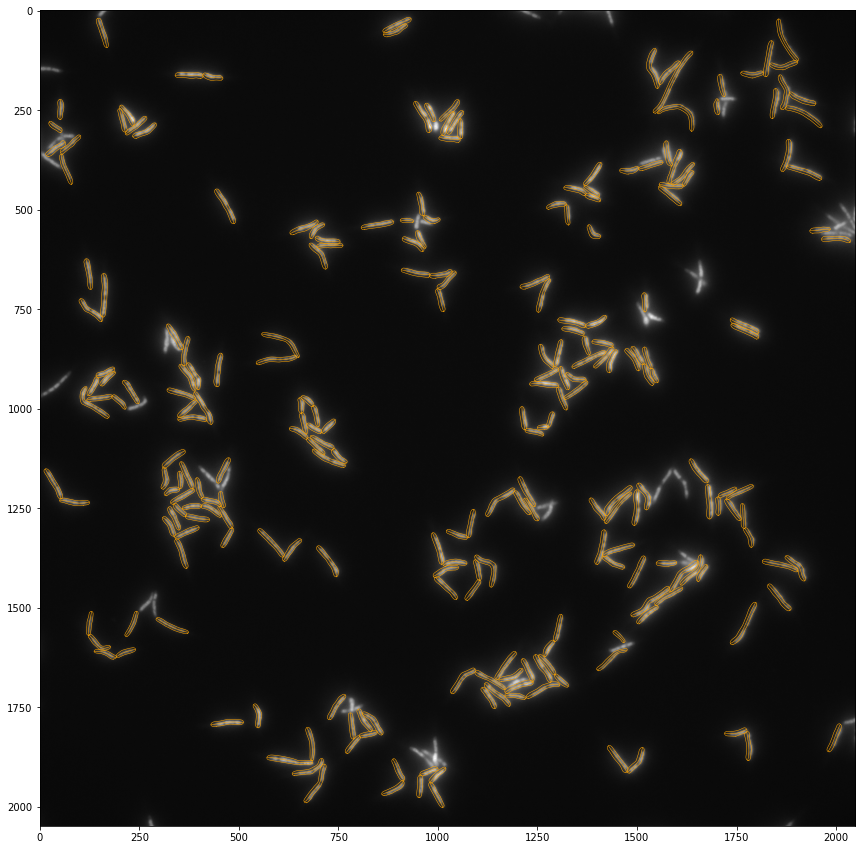

In [23]:
p.plot(figsize=(15,15),channel='FITC',contour_prop={'lw':0.5},midline_prop={'lw':0.5})